In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pybaseball import statcast, cache
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import joblib
import math
from pybaseball import statcast
import scipy.stats as stats
from catboost import Pool
import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score
import sqlite3
cache.enable()

In [2]:
with sqlite3.connect("../../Desktop/MLB Statcast.db") as conn:
    sc_23 = pd.read_sql_query("SELECT * FROM statcast_data_2023", conn)
    sc_22 = pd.read_sql_query("SELECT * FROM statcast_data_2022", conn)
    sc_21 = pd.read_sql_query("SELECT * FROM statcast_data_2021", conn)
    sc_20 = pd.read_sql_query("SELECT * FROM statcast_data_2020", conn)
conn.close()

In [3]:
spin_23 = pd.read_csv('../../Documents/spin_dir_2023.csv').drop(columns=['release_speed'])
spin_22 = pd.read_csv('../../Documents/spin_dir_2022.csv').drop(columns=['release_speed'])
spin_21 = pd.read_csv('../../Documents/spin_dir_2021.csv').drop(columns=['release_speed'])
spin_20 = pd.read_csv('../../Documents/spin_dir_2020.csv').drop(columns=['release_speed'])

In [4]:
sc_23 = pd.merge(sc_23, spin_23, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_22 = pd.merge(sc_22, spin_22, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_21 = pd.merge(sc_21, spin_21, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')
sc_20 = pd.merge(sc_20, spin_20, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')

In [5]:
total_sc = pd.concat([sc_23, sc_22, sc_21, sc_20])

In [6]:
[c for c in total_sc.columns]

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'fielder_2',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'pitcher.1',
 'fielder_2.1',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimat

In [7]:
total_sc['axis_dif'] = total_sc['diff_clock_hh'] * 10 + total_sc['diff_clock_mm']

In [8]:
features = ['release_speed', 'spin_axis', 'axis_dif', 'active_spin', 'pfx_x', 'pfx_z', 'release_extension', 'release_pos_x', 'release_pos_z']
total_sc = total_sc[total_sc[features].notnull().all(axis=1)]

In [9]:
total_sc.loc[total_sc['p_throws'] == 'L', 'pfx_x'] *= -1
total_sc.loc[total_sc['p_throws'] == 'L', 'release_pos_x'] *= -1
total_sc.loc[total_sc['p_throws'] == 'L', 'spin_axis'] = 360 - total_sc.loc[total_sc['p_throws'] == 'L', 'spin_axis']

In [10]:
total_sc = total_sc[~total_sc['pitch_name'].isin(['Pitch Out', 'Eephus', 'Knuckleball'])]

In [11]:
fastballs = ['4-Seam Fastball', 'Sinker']
offspeed = ['Split-Finger', 'Changeup', 'Forkball']
breaking = ['Curveball', 'Slider', 'Cutter', 'Knuckle Curve', 'Sweeper', 'Screwball', 'Slow Curve']

In [12]:
def get_pitch_data(total_sc, pitch_name, players):
    pitch_data = total_sc.loc[(total_sc['pitch_name'] == pitch_name) & (total_sc['player_name'].isin(players))]
    grouped_data = pitch_data.groupby('player_name').agg({
        'release_speed': 'median',
        'pfx_x': 'median',
        'pfx_z': 'median'
    }).reset_index()
    
    return grouped_data

all_players = total_sc['player_name'].unique()

fastball_data = get_pitch_data(total_sc, '4-Seam Fastball', all_players)
fastball_data = fastball_data.dropna(subset=['release_speed'])
fastball_velo_map = dict(zip(fastball_data['player_name'], fastball_data['release_speed']))
fastball_h_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_x']))
fastball_v_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_z']))

sinker_data = get_pitch_data(total_sc, 'Sinker', all_players)
sinker_data = sinker_data.dropna(subset=['release_speed'])
sinker_velo_map = dict(zip(sinker_data['player_name'], sinker_data['release_speed']))
sinker_h_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_x']))
sinker_v_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_z']))

cutter_data = get_pitch_data(total_sc, 'Cutter', all_players)
cutter_data = cutter_data.dropna(subset=['release_speed'])
cutter_velo_map = dict(zip(cutter_data['player_name'], cutter_data['release_speed']))
cutter_h_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_x']))
cutter_v_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_z']))

In [13]:
pitch_data = {
    '4-Seam Fastball': {
        'velo_map': fastball_velo_map,
        'h_mov_map': fastball_h_mov_map,
        'v_mov_map': fastball_v_mov_map
    },
    'Sinker': {
        'velo_map': sinker_velo_map,
        'h_mov_map': sinker_h_mov_map,
        'v_mov_map': sinker_v_mov_map
    },
    'Cutter': {
        'velo_map': cutter_velo_map,
        'h_mov_map': cutter_h_mov_map,
        'v_mov_map': cutter_v_mov_map
    }
}

def calculate_differences(row):
    player_name = row['player_name']
    for pitch_type in ['4-Seam Fastball', 'Sinker', 'Cutter']:
        if player_name in pitch_data[pitch_type]['velo_map']:
            velo_dif = row['release_speed'] - pitch_data[pitch_type]['velo_map'][player_name]
            h_mov_dif = row['pfx_x'] - pitch_data[pitch_type]['h_mov_map'][player_name]
            v_mov_dif = row['pfx_z'] - pitch_data[pitch_type]['v_mov_map'][player_name]
            return velo_dif, h_mov_dif, v_mov_dif

    return np.nan, np.nan, np.nan

total_sc['velo_dif'], total_sc['h_mov_dif'], total_sc['v_mov_dif'] = zip(*total_sc.apply(calculate_differences, axis=1))

In [14]:
total_sc = total_sc[(total_sc['velo_dif'] <= 0) | (total_sc['pitch_name'].isin(['Sinker', '4-Seam Fastball']))]

In [15]:
features_with_dif = features + ['h_mov_dif', 'v_mov_dif', 'velo_dif']

In [16]:
total_sc['description'] = np.where(total_sc['description'] == 'hit_into_play', total_sc['events'], total_sc['description'])
field_outs = ['force_out', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'field_out', 'double_play', 'sac_fly', 'field_error', 'sac_fly_double_play', 'triple_play']
total_sc['description'] = total_sc['description'].replace(field_outs, 'field_out')

In [17]:
total_sc.description.unique()

array(['swinging_strike', 'foul', 'called_strike', 'field_out', 'ball',
       'single', 'foul_tip', 'swinging_strike_blocked', 'blocked_ball',
       'double', 'hit_by_pitch', 'sac_bunt', 'home_run', 'triple',
       'foul_bunt', 'missed_bunt', 'bunt_foul_tip', 'catcher_interf',
       'unknown_strike', 'sac_bunt_double_play'], dtype=object)

In [18]:
total_sc['whiff'] = total_sc['description'].isin(['swinging_strike', 'swinging_strike_blocked'])
total_sc['foul'] = total_sc['description'].isin(['foul', 'foul_tip'])
total_sc['in_play'] = total_sc['description'].isin(['single', 'double', 'triple', 'home_run', 'field_out'])
total_sc['swing'] = (total_sc['whiff'] | total_sc['foul'] | total_sc['in_play'])

total_sc['take'] = (~total_sc['swing'] & (total_sc['description'].isin(['hit_by_pitch', 'ball', 'called_strike', 'blocked_ball'])))
total_sc['hbp'] = total_sc['description'] == 'hit_by_pitch'
total_sc['ball'] = total_sc['description'].isin(['blocked_ball', 'ball'])
total_sc['strike'] = total_sc['description'] == 'called_strike'

total_sc['single'] = total_sc['description'] == 'single'
total_sc['double'] = total_sc['description'] == 'double'
total_sc['triple'] = total_sc['description'] == 'triple'
total_sc['home_run'] = total_sc['description'] == 'home_run'
total_sc['field_out'] = total_sc['description'] == 'field_out'

In [19]:
total_sc.loc[total_sc['swing'] & total_sc['foul'], 'type_swing'] = 'foul'
total_sc.loc[total_sc['swing'] & total_sc['in_play'], 'type_swing'] = 'in_play'
total_sc.loc[total_sc['swing'] & total_sc['whiff'], 'type_swing'] = 'whiff'

total_sc.loc[total_sc['take'] & total_sc['hbp'], 'type_take'] = 'hbp'
total_sc.loc[total_sc['take'] & total_sc['ball'], 'type_take'] = 'ball'
total_sc.loc[total_sc['take'] & total_sc['strike'], 'type_take'] = 'strike'

total_sc.loc[total_sc['in_play'] & total_sc['single'], 'type_in_play'] = 'single'
total_sc.loc[total_sc['in_play'] & total_sc['double'], 'type_in_play'] = 'double'
total_sc.loc[total_sc['in_play'] & total_sc['triple'], 'type_in_play'] = 'triple'
total_sc.loc[total_sc['in_play'] & total_sc['home_run'], 'type_in_play'] = 'home_run'
total_sc.loc[total_sc['in_play'] & total_sc['field_out'], 'type_in_play'] = 'field_out'

In [20]:
total_sc = total_sc.dropna(subset=['swing', 'take'])
total_sc = total_sc[total_sc['swing'] != total_sc['take']]

In [21]:
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp, fmin, tpe

def objective(space, X_train, X_test, y_train, y_test):
    model = XGBClassifier(
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        n_estimators=int(space['n_estimators']))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

le_swing = LabelEncoder()

swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(fastballs)]
swing_X = swing_df[features]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())

space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'seed': 12
}

best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print("Best parameters:", best_params)

swing_model = XGBClassifier(**best_params)
swing_model.fit(X_train, y_train)

100%|██████████████████████████████████████████████| 10/10 [07:45<00:00, 46.57s/trial, best loss: -0.47017993486037696]
Best parameters: {'max_depth': 17, 'gamma': 2.404963253663013, 'reg_alpha': 72, 'reg_lambda': 0.618879288025503, 'colsample_bytree': 0.7230698008236222, 'min_child_weight': 7, 'n_estimators': 51}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7230698008236222, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.404963253663013, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=17, max_leaves=0,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=51, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [22]:
swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(breaking)]
swing_X = swing_df[features_with_dif]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())

best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

swing_bb_model = XGBClassifier(**best_params)
swing_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [04:18<00:00, 25.81s/trial, best loss: -0.3893312197523748]
{'max_depth': 18, 'gamma': 1.4093297456693428, 'reg_alpha': 146, 'reg_lambda': 0.2509100478511388, 'colsample_bytree': 0.7909592865776568, 'min_child_weight': 8, 'n_estimators': 164}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7909592865776568, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.4093297456693428, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=18, max_leaves=0,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=164, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [23]:
swing_df = total_sc[(total_sc['swing']) & total_sc['pitch_name'].isin(offspeed)]
swing_X = swing_df[features_with_dif]
swing_y = le_swing.fit_transform(swing_df['type_swing'])

X_train, X_test, y_train, y_test = train_test_split(swing_X, swing_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

swing_offs_model = XGBClassifier(**best_params)
swing_offs_model.fit(X_train, y_train)

100%|██████████████████████████████████████████████| 10/10 [01:24<00:00,  8.48s/trial, best loss: -0.39183941880127765]
{'max_depth': 11, 'gamma': 3.3206823826292498, 'reg_alpha': 103, 'reg_lambda': 0.2745177951942098, 'colsample_bytree': 0.9266954381784882, 'min_child_weight': 4, 'n_estimators': 165}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9266954381784882, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.3206823826292498, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=11, max_leaves=0,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=165, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [24]:
le_take = LabelEncoder()

take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(fastballs)]
take_X = take_total_sc[features]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_model = XGBClassifier(**best_params)
take_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [06:25<00:00, 38.55s/trial, best loss: -0.6396689633325414]
{'max_depth': 16, 'gamma': 6.748553969283782, 'reg_alpha': 180, 'reg_lambda': 0.43140900262323234, 'colsample_bytree': 0.5151326798928344, 'min_child_weight': 2, 'n_estimators': 76}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5151326798928344, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6.748553969283782, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=16, max_leaves=0,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=76, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [25]:
take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(breaking)]
take_X = take_total_sc[features_with_dif]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_bb_model = XGBClassifier(**best_params)
take_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [03:25<00:00, 20.57s/trial, best loss: -0.6929824561403509]
{'max_depth': 15, 'gamma': 2.3355238880441194, 'reg_alpha': 123, 'reg_lambda': 0.4261802944977624, 'colsample_bytree': 0.5764106552382964, 'min_child_weight': 7, 'n_estimators': 169}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5764106552382964, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.3355238880441194, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=169, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [26]:
take_total_sc = total_sc[(total_sc['take']) & total_sc['pitch_name'].isin(offspeed)]
take_X = take_total_sc[features_with_dif]
take_y = le_take.fit_transform(take_total_sc['type_take'])

X_train, X_test, y_train, y_test = train_test_split(take_X, take_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

take_offs_model = XGBClassifier(**best_params)
take_offs_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [01:10<00:00,  7.08s/trial, best loss: -0.8063506552780857]
{'max_depth': 15, 'gamma': 1.4433978441527424, 'reg_alpha': 109, 'reg_lambda': 0.8477231849619582, 'colsample_bytree': 0.9876504072362184, 'min_child_weight': 1, 'n_estimators': 159}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9876504072362184, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.4433978441527424, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=159, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [27]:
le_woba = LabelEncoder()

woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(fastballs)]
woba_X = woba_total_sc[features]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_model = XGBClassifier(**best_params)
woba_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [03:19<00:00, 19.95s/trial, best loss: -0.6630962343096234]
{'max_depth': 8, 'gamma': 7.511040561357324, 'reg_alpha': 86, 'reg_lambda': 0.25347123564139995, 'colsample_bytree': 0.9115225346798999, 'min_child_weight': 3, 'n_estimators': 126}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9115225346798999, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.511040561357324, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=126, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [28]:
woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(breaking)]
woba_X = woba_total_sc[features_with_dif]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_bb_model = XGBClassifier(**best_params)
woba_bb_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [02:49<00:00, 16.94s/trial, best loss: -0.6856637413715356]
{'max_depth': 15, 'gamma': 2.813016611394988, 'reg_alpha': 106, 'reg_lambda': 0.12437418694230273, 'colsample_bytree': 0.8210491833721603, 'min_child_weight': 3, 'n_estimators': 145}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8210491833721603, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.813016611394988, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=145, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [29]:
woba_total_sc = total_sc[(total_sc['in_play']) & total_sc['pitch_name'].isin(offspeed)]
woba_X = woba_total_sc[features_with_dif]
woba_y = le_woba.fit_transform(woba_total_sc['type_in_play'])

X_train, X_test, y_train, y_test = train_test_split(woba_X, woba_y, test_size=0.2, random_state=np.random.seed())
best_params = fmin(fn=lambda params: objective(params, X_train, X_test, y_train, y_test),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=10)
best_params = {
    'max_depth': int(best_params['max_depth']),
    'gamma': float(best_params['gamma']),
    'reg_alpha': int(best_params['reg_alpha']),
    'reg_lambda': float(best_params['reg_lambda']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'min_child_weight': int(best_params['min_child_weight']),
    'n_estimators': int(best_params['n_estimators'])
}
print(best_params)

woba_offs_model = XGBClassifier(**best_params)
woba_offs_model.fit(X_train, y_train)

100%|███████████████████████████████████████████████| 10/10 [01:00<00:00,  6.02s/trial, best loss: -0.6950925849040936]
{'max_depth': 16, 'gamma': 6.353937926159211, 'reg_alpha': 176, 'reg_lambda': 0.8877154390947146, 'colsample_bytree': 0.7425726894053126, 'min_child_weight': 1, 'n_estimators': 96}


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7425726894053126, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6.353937926159211, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=16, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=96, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [30]:
def will_swing_objective(trial, will_swing_X, will_swing_y):
    X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())
    
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", .05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
    }

    model = CatBoostClassifier(**params, silent=True, thread_count=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (swing)
    logloss = log_loss(y_test, y_pred)
    return logloss

will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(fastballs)]
will_swing_X = will_swing_total_sc[features]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=3)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_model = CatBoostClassifier(**best_params, silent=True)
will_swing_model.fit(X_train, y_train)

[I 2023-12-01 17:46:14,100] A new study created in memory with name: no-name-5f8ec7a5-6092-48e4-a2bc-c48d728fc351
[I 2023-12-01 17:48:21,912] Trial 0 finished with value: 0.68786115091938 and parameters: {'iterations': 1745, 'learning_rate': 0.09073359218126269, 'depth': 5, 'colsample_bylevel': 0.2567307333722632, 'min_data_in_leaf': 56}. Best is trial 0 with value: 0.68786115091938.
[I 2023-12-01 17:49:43,164] Trial 1 finished with value: 0.6884511795164956 and parameters: {'iterations': 1422, 'learning_rate': 0.05587345637815223, 'depth': 4, 'colsample_bylevel': 0.16580540571131475, 'min_data_in_leaf': 54}. Best is trial 1 with value: 0.6884511795164956.
[I 2023-12-01 17:50:57,390] Trial 2 finished with value: 0.688747147098528 and parameters: {'iterations': 1329, 'learning_rate': 0.043913899300885614, 'depth': 2, 'colsample_bylevel': 0.48323743624754606, 'min_data_in_leaf': 42}. Best is trial 2 with value: 0.688747147098528.


Best hyperparameters: {'iterations': 1329, 'learning_rate': 0.043913899300885614, 'depth': 2, 'colsample_bylevel': 0.48323743624754606, 'min_data_in_leaf': 42}
Best logloss: 0.688747147098528


In [31]:
will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(breaking)]
will_swing_X = will_swing_total_sc[features_with_dif]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=3)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_bb_model = CatBoostClassifier(**best_params, silent=True)
will_swing_bb_model.fit(X_train, y_train)

[I 2023-12-01 17:52:14,637] A new study created in memory with name: no-name-b316e01d-5381-4796-bd2d-9c5e084c21d1
[I 2023-12-01 17:54:01,375] Trial 0 finished with value: 0.6857083313464432 and parameters: {'iterations': 1495, 'learning_rate': 0.0016657021119486442, 'depth': 6, 'colsample_bylevel': 0.6645138234173534, 'min_data_in_leaf': 73}. Best is trial 0 with value: 0.6857083313464432.
[I 2023-12-01 17:55:10,860] Trial 1 finished with value: 0.6843884106119735 and parameters: {'iterations': 1107, 'learning_rate': 0.013843175216743909, 'depth': 5, 'colsample_bylevel': 0.7020816341306978, 'min_data_in_leaf': 36}. Best is trial 0 with value: 0.6857083313464432.
[I 2023-12-01 17:56:36,799] Trial 2 finished with value: 0.6837092779270618 and parameters: {'iterations': 1043, 'learning_rate': 0.008019698975030328, 'depth': 10, 'colsample_bylevel': 0.21541474876370525, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.6857083313464432.


Best hyperparameters: {'iterations': 1495, 'learning_rate': 0.0016657021119486442, 'depth': 6, 'colsample_bylevel': 0.6645138234173534, 'min_data_in_leaf': 73}
Best logloss: 0.6857083313464432


In [32]:
will_swing_total_sc = total_sc[total_sc['pitch_name'].isin(offspeed)]
will_swing_X = will_swing_total_sc[features_with_dif]
will_swing_y = will_swing_total_sc['swing']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: will_swing_objective(trial, will_swing_X, will_swing_y), n_trials=3)
best_params = study.best_params
best_ll = study.best_value

print('Best hyperparameters:', best_params)
print('Best logloss:', best_ll)
X_train, X_test, y_train, y_test = train_test_split(will_swing_X, will_swing_y, test_size=0.2, random_state=np.random.seed())

will_swing_offs_model = CatBoostClassifier(**best_params, silent=True)
will_swing_offs_model.fit(X_train, y_train)

[I 2023-12-01 17:58:27,292] A new study created in memory with name: no-name-290ebe72-855d-4ef3-a069-fb431234ae3f
[I 2023-12-01 17:59:10,689] Trial 0 finished with value: 0.6887381899512859 and parameters: {'iterations': 1358, 'learning_rate': 0.010401209629370379, 'depth': 7, 'colsample_bylevel': 0.4920574122429006, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.6887381899512859.
[I 2023-12-01 17:59:50,984] Trial 1 finished with value: 0.6883695757653415 and parameters: {'iterations': 1080, 'learning_rate': 0.008976374740724668, 'depth': 8, 'colsample_bylevel': 0.7309140907385426, 'min_data_in_leaf': 31}. Best is trial 0 with value: 0.6887381899512859.
[I 2023-12-01 18:00:10,512] Trial 2 finished with value: 0.6912594240696567 and parameters: {'iterations': 1255, 'learning_rate': 0.010932768580753817, 'depth': 2, 'colsample_bylevel': 0.09821555235664291, 'min_data_in_leaf': 21}. Best is trial 2 with value: 0.6912594240696567.


Best hyperparameters: {'iterations': 1255, 'learning_rate': 0.010932768580753817, 'depth': 2, 'colsample_bylevel': 0.09821555235664291, 'min_data_in_leaf': 21}
Best logloss: 0.6912594240696567


In [33]:
with sqlite3.connect("../../Desktop/MLB Statcast.db") as conn:
    sc_23 = pd.read_sql_query("SELECT * FROM statcast_data_2023", conn)
conn.close()
spin_23 = pd.read_csv('../../Documents/spin_dir_2023.csv').drop(columns=['release_speed'])
sc_23 = pd.merge(sc_23, spin_23, left_on=['player_name', 'pitch_type'], right_on=['last_name, first_name', 'api_pitch_type'], how='left')

In [34]:
sc_23.loc[sc_23['p_throws'] == 'L', 'pfx_x'] *= -1
sc_23.loc[sc_23['p_throws'] == 'L', 'release_pos_x'] *= -1
sc_23.loc[sc_23['p_throws'] == 'L', 'spin_axis'] = 360 - sc_23.loc[sc_23['p_throws'] == 'L', 'spin_axis']

In [35]:
sc_23['axis_dif'] = sc_23['diff_clock_hh'] * 10 + sc_23['diff_clock_mm']

In [36]:
sc_23 = sc_23[sc_23[features].notnull().all(axis=1)]

In [37]:
all_players = sc_23['player_name'].unique()

fastball_data = get_pitch_data(sc_23, '4-Seam Fastball', all_players)
fastball_data = fastball_data.dropna(subset=['release_speed'])
fastball_velo_map = dict(zip(fastball_data['player_name'], fastball_data['release_speed']))
fastball_h_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_x']))
fastball_v_mov_map = dict(zip(fastball_data['player_name'], fastball_data['pfx_z']))

sinker_data = get_pitch_data(sc_23, 'Sinker', all_players)
sinker_data = sinker_data.dropna(subset=['release_speed'])
sinker_velo_map = dict(zip(sinker_data['player_name'], sinker_data['release_speed']))
sinker_h_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_x']))
sinker_v_mov_map = dict(zip(sinker_data['player_name'], sinker_data['pfx_z']))

cutter_data = get_pitch_data(sc_23, 'Cutter', all_players)
cutter_data = cutter_data.dropna(subset=['release_speed'])
cutter_velo_map = dict(zip(cutter_data['player_name'], cutter_data['release_speed']))
cutter_h_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_x']))
cutter_v_mov_map = dict(zip(cutter_data['player_name'], cutter_data['pfx_z']))

In [38]:
pitch_data = {
    '4-Seam Fastball': {
        'velo_map': fastball_velo_map,
        'h_mov_map': fastball_h_mov_map,
        'v_mov_map': fastball_v_mov_map
    },
    'Sinker': {
        'velo_map': sinker_velo_map,
        'h_mov_map': sinker_h_mov_map,
        'v_mov_map': sinker_v_mov_map
    },
    'Cutter': {
        'velo_map': cutter_velo_map,
        'h_mov_map': cutter_h_mov_map,
        'v_mov_map': cutter_v_mov_map
    }
}

sc_23['velo_dif'], sc_23['h_mov_dif'], sc_23['v_mov_dif'] = zip(*sc_23.apply(calculate_differences, axis=1))

In [39]:
fastball_df = sc_23[sc_23['pitch_name'].isin(fastballs)]
bb_df = sc_23[sc_23['pitch_name'].isin(breaking)]
offs_df = sc_23[sc_23['pitch_name'].isin(offspeed)]

In [40]:
values = {
    'home_run': 1.374328827219,
    'triple': 1.05755624961515,
    'double': 0.766083123898271,
    'single': 0.467292970729251,
    'ball': 0.0636883289483747,
    'hit_by_pitch': 0.0636883289483747,
    'blocked_ball': 0.0636883289483747,
    'foul': -0.0380502742575014,
    'foul_tip': -0.0380502742575014,
    'bunt_foul': -0.0380502742575014,
    'bunt_foul_tip': -0.0380502742575014,
    'called_strike': -0.065092516089806,
    'swinging_strike': -0.118124935770601,
    'swinging_strike_blocked': -0.118124935770601,
    'force_out': -0.1955687665555,
    'grounded_into_double_play': -0.1955687665555,
    'fielders_choice_out': -0.1955687665555,
    'fielders_choice': -0.1955687665555,
    'field_out': -0.1955687665555,
    'double_play': -0.1955687665555,
    'sac_fly': -0.236889645519856,
    'field_error': -0.236889645519856,
    'catcher_interf': -0.789788814378052,
    'sac_fly_double_play': -0.789788814378052,
    'triple_play': -0.789788814378052
}

In [41]:
swing_probs = swing_model.predict_proba(fastball_df[features])
take_probs = take_model.predict_proba(fastball_df[features])
ws_probs = will_swing_model.predict_proba(fastball_df[features])
woba_probs = woba_model.predict_proba(fastball_df[features])

fastball_df['whiff_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('whiff')]
fastball_df['in_play_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('in_play')]
fastball_df['foul_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('foul')]

fastball_df['strike_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('strike')]
fastball_df['ball_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('ball')]
fastball_df['hbp_prob'] = take_probs[:, list(le_take.inverse_transform(take_model.classes_)).index('hbp')]

fastball_df['single_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('single')]
fastball_df['double_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('double')]
fastball_df['triple_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('triple')]
fastball_df['hr_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('home_run')]
fastball_df['fo_prob'] = woba_probs[:, list(le_woba.inverse_transform(woba_model.classes_)).index('field_out')]
fastball_df['xwOBAcon'] = values['single'] * fastball_df['single_prob'] + values['double'] * fastball_df['double_prob'] + values['triple'] * fastball_df['triple_prob'] + values['home_run'] * fastball_df['hr_prob'] + values['field_out'] * fastball_df['fo_prob']

fastball_df['swing_prob'] = ws_probs[:, list(will_swing_model.classes_).index('True')]
fastball_df['take_prob'] = 1 - fastball_df['swing_prob'] 

fastball_df['val_swing'] = values['swinging_strike'] * fastball_df['whiff_prob'] + values['foul'] * fastball_df['foul_prob']
+ fastball_df['xwOBAcon'] * fastball_df['in_play_prob']
fastball_df['val_take'] = values['called_strike'] * fastball_df['strike_prob'] + values['ball'] * fastball_df['ball_prob'] + values['hit_by_pitch'] * fastball_df['hbp_prob']
fastball_df['xRV'] = fastball_df['val_swing'] * fastball_df['swing_prob'] + fastball_df['val_take'] * fastball_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_18860\3806814061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['whiff_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_18860\3806814061.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_df['in_play_prob'] = swing_probs[:, list(le_swing.inverse_transform(swing_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_1886

In [42]:
swing_bb_probs = swing_bb_model.predict_proba(bb_df[features_with_dif])
take_bb_probs = take_bb_model.predict_proba(bb_df[features_with_dif])
ws_bb_probs = will_swing_bb_model.predict_proba(bb_df[features_with_dif])
woba_bb_probs = woba_bb_model.predict_proba(bb_df[features_with_dif])

bb_df['whiff_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('whiff')]
bb_df['in_play_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('in_play')]
bb_df['foul_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('foul')]

bb_df['strike_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('strike')]
bb_df['ball_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('ball')]
bb_df['hbp_prob'] = take_bb_probs[:, list(le_take.inverse_transform(take_bb_model.classes_)).index('hbp')]

bb_df['single_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('single')]
bb_df['double_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('double')]
bb_df['triple_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('triple')]
bb_df['hr_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('home_run')]
bb_df['fo_prob'] = woba_bb_probs[:, list(le_woba.inverse_transform(woba_bb_model.classes_)).index('field_out')]
bb_df['xwOBAcon'] = values['single'] * bb_df['single_prob'] + values['double'] * bb_df['double_prob'] + values['triple'] * bb_df['triple_prob'] + values['home_run'] * bb_df['hr_prob'] + values['field_out'] * bb_df['fo_prob']

bb_df['swing_prob'] = ws_bb_probs[:, list(will_swing_bb_model.classes_).index('True')]
bb_df['take_prob'] = 1 - bb_df['swing_prob'] 

bb_df['val_swing'] = values['swinging_strike'] * bb_df['whiff_prob'] + values['foul'] * bb_df['foul_prob']
+ bb_df['xwOBAcon'] * bb_df['in_play_prob']
bb_df['val_take'] = values['called_strike'] * bb_df['strike_prob'] + values['ball'] * bb_df['ball_prob'] + values['hit_by_pitch'] * bb_df['hbp_prob']
bb_df['xRV'] = bb_df['val_swing'] * bb_df['swing_prob'] + bb_df['val_take'] * bb_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_18860\1959749140.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['whiff_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_18860\1959749140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb_df['in_play_prob'] = swing_bb_probs[:, list(le_swing.inverse_transform(swing_bb_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_1886

In [43]:
swing_offs_probs = swing_offs_model.predict_proba(offs_df[features_with_dif])
take_offs_probs = take_offs_model.predict_proba(offs_df[features_with_dif])
ws_offs_probs = will_swing_offs_model.predict_proba(offs_df[features_with_dif])
woba_offs_probs = woba_offs_model.predict_proba(offs_df[features_with_dif])

offs_df['whiff_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('whiff')]
offs_df['in_play_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('in_play')]
offs_df['foul_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('foul')]

offs_df['strike_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('strike')]
offs_df['ball_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('ball')]
offs_df['hbp_prob'] = take_offs_probs[:, list(le_take.inverse_transform(take_offs_model.classes_)).index('hbp')]

offs_df['single_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('single')]
offs_df['double_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('double')]
offs_df['triple_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('triple')]
offs_df['hr_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('home_run')]
offs_df['fo_prob'] = woba_offs_probs[:, list(le_woba.inverse_transform(woba_offs_model.classes_)).index('field_out')]
offs_df['xwOBAcon'] = values['single'] * offs_df['single_prob'] + values['double'] * offs_df['double_prob'] + values['triple'] * offs_df['triple_prob'] + values['home_run'] * offs_df['hr_prob'] + values['field_out'] * offs_df['fo_prob']

offs_df['swing_prob'] = ws_offs_probs[:, list(will_swing_offs_model.classes_).index('True')]
offs_df['take_prob'] = 1 - offs_df['swing_prob'] 

offs_df['val_swing'] = values['swinging_strike'] * offs_df['whiff_prob'] + values['foul'] * offs_df['foul_prob']
+ offs_df['xwOBAcon'] * offs_df['in_play_prob']
offs_df['val_take'] = values['called_strike'] * offs_df['strike_prob'] + values['ball'] * offs_df['ball_prob'] + values['hit_by_pitch'] * offs_df['hbp_prob']
offs_df['xRV'] = offs_df['val_swing'] * offs_df['swing_prob'] + offs_df['val_take'] * offs_df['take_prob']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_18860\3390110069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offs_df['whiff_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('whiff')]
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_18860\3390110069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offs_df['in_play_prob'] = swing_offs_probs[:, list(le_swing.inverse_transform(swing_offs_model.classes_)).index('in_play')]
C:\Users\kellyjc\AppData\Local\Temp\ip

In [44]:
total_df = pd.concat([fastball_df, bb_df, offs_df])

In [45]:
def calculate_stuff_plus(pitch_sc, min_num_pitches=100):
    agg_stuff_plus = pitch_sc.groupby(['player_name', 'pitch_name']).agg(
        mean_xrv=('xRV', 'mean'),
        mean_rv=('delta_run_exp', 'mean'),
        num_pitches=('player_name', 'count'),
        velo=('release_speed', 'mean'),
        spin_rate=('release_spin_rate', 'mean'),
        vert_break=('pfx_z', 'mean'),
        horz_break=('pfx_x', 'mean')
    ).reset_index()
    
    agg_stuff_plus['xrv_100'] = agg_stuff_plus['mean_xrv'] * 100
    agg_stuff_plus['xrv_100_adj'] = abs(agg_stuff_plus['xrv_100'] - agg_stuff_plus['xrv_100'].max())
    agg_stuff_plus['stuff_plus'] = (agg_stuff_plus['xrv_100_adj'] / agg_stuff_plus['xrv_100_adj'].mean()) * 100
    agg_stuff_plus = agg_stuff_plus.sort_values('stuff_plus', ascending=False)

    agg_stuff_plus = agg_stuff_plus[agg_stuff_plus['num_pitches'] > min_num_pitches]

    return agg_stuff_plus

def calculate_agg_stuff_plus(pitch_sc, min_num_pitches=100):
    agg_stuff_plus = pitch_sc.groupby(['player_name']).agg(
        mean_xrv=('xRV', 'mean'),  
        swing_prob=('swing_prob', 'mean'),
        whiff_prob=('whiff_prob', 'mean'),
        take_prob=('take_prob', 'mean'),
        xwobacon=('xwOBAcon', 'mean'),
        fo_prob=('fo_prob', 'mean'),
        mean_rv=('delta_run_exp', 'mean'),
        num_pitches=('player_name', 'count'),
        velo=('release_speed', 'mean'),
        spin_rate=('release_spin_rate', 'mean'),
        vert_break=('pfx_z', 'mean'),
        horz_break=('pfx_x', 'mean')
    ).reset_index()

    agg_stuff_plus['xrv_100'] = agg_stuff_plus['mean_xrv'] * 100
    agg_stuff_plus['xrv_100_adj'] = abs(agg_stuff_plus['xrv_100'] - agg_stuff_plus['xrv_100'].max())
    agg_stuff_plus['stuff_plus'] = (agg_stuff_plus['xrv_100_adj'] / agg_stuff_plus['xrv_100_adj'].mean()) * 100
    agg_stuff_plus = agg_stuff_plus.sort_values('stuff_plus', ascending=False)

    agg_stuff_plus = agg_stuff_plus[agg_stuff_plus['num_pitches'] > min_num_pitches]

    return agg_stuff_plus

agg_total = calculate_agg_stuff_plus(total_df, 700)
agg_fb = calculate_stuff_plus(fastball_df, 300)
agg_bb = calculate_stuff_plus(bb_df, 300)
agg_offs = calculate_stuff_plus(offs_df, 300)

In [46]:
agg_total

,player_name,mean_xrv,swing_prob,whiff_prob,take_prob,xwobacon,fo_prob,mean_rv,num_pitches,velo,spin_rate,vert_break,horz_break,xrv_100,xrv_100_adj,stuff_plus
47,"Bautista, Félix",-0.017791,0.537055,0.326919,0.462945,0.080915,0.689525,-0.024546,1001,96.129071,2038.611389,1.361848,-0.526663,-1.779129,1.520793,255.984387
271,"Hader, Josh",-0.015855,0.504632,0.322917,0.495368,0.091227,0.679524,-0.018249,1020,93.436373,2178.603922,1.215480,-0.456892,-1.585528,1.327192,223.396870
639,"Sewald, Paul",-0.014787,0.496604,0.283535,0.503396,0.098245,0.668372,-0.006125,1202,88.845757,2507.632280,0.980915,-0.137970,-1.478749,1.220413,205.423518
631,"Scott, Tanner",-0.014755,0.502468,0.340442,0.497532,0.090126,0.670819,-0.019359,1230,92.890407,2669.392683,0.581073,0.129008,-1.475481,1.217145,204.873379
200,"Fairbanks, Pete",-0.014657,0.488058,0.310555,0.511942,0.083877,0.680212,-0.021355,737,92.808955,2482.377205,0.502809,0.159674,-1.465694,1.207358,203.226130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,"Thompson, Zack",-0.004105,0.454929,0.227677,0.545071,0.097272,0.665099,-0.003799,1191,87.086818,2111.210747,0.322401,-0.159647,-0.410532,0.152197,25.618171
183,"Dunning, Dane",-0.003995,0.465418,0.211527,0.534582,0.083757,0.672791,-0.006606,2821,87.032719,2121.520737,0.385193,-0.509383,-0.399523,0.141187,23.765004
219,"Freeland, Kyle",-0.003452,0.452459,0.189005,0.547541,0.088681,0.669316,0.007016,2401,85.654561,2232.628072,0.475664,-0.460666,-0.345163,0.086827,14.614959
291,"Hendricks, Kyle",-0.003408,0.453843,0.182282,0.546157,0.082988,0.674483,-0.003640,2107,84.271856,2131.005221,0.699748,-0.752496,-0.340846,0.082510,13.888330


Correlation: -0.3336437920313322


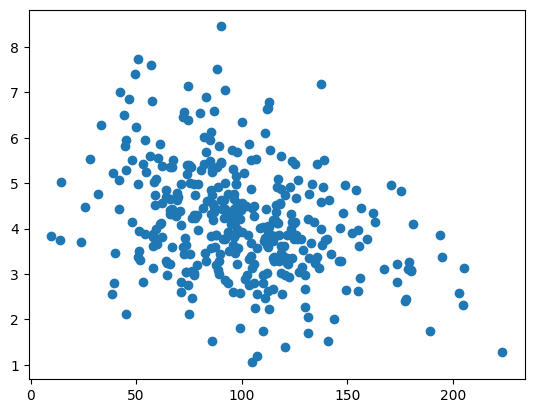

In [57]:
from pybaseball import pitching_stats_bref
import matplotlib.pyplot as plt

data = pitching_stats_bref(2023)

agg_sp = pd.read_csv('../../Downloads/Stuff+ 2023 - Sheet1.csv')

agg_total[['Last Name', 'First Name']] = agg_total['player_name'].str.split(', ', expand=True)
agg_total['Full Name'] = agg_total['First Name'] + ' ' + agg_total['Last Name']
# agg_total = agg_total.merge(agg_sp, left_on=['Full Name'], right_on=['Name'], how='inner')
stats_stuff = data.merge(agg_total, left_on='Name', right_on='Full Name', how='inner')

x = stats_stuff['stuff_plus']
y = stats_stuff['ERA']

plt.scatter(x, y)

corr_matrix = np.corrcoef(x, y)
corr = corr_matrix[0,1]
print(f'Correlation: {corr}')

# Show the plot
plt.show()

In [48]:
joblib.dump(woba_model, 'stuff_woba_fb.joblib')
joblib.dump(take_model, 'stuff_take_fb.joblib')
joblib.dump(will_swing_model, 'stuff_ws_fb.joblib')
joblib.dump(swing_model, 'stuff_swing_fb.joblib')

joblib.dump(woba_bb_model, 'stuff_woba_bb.joblib')
joblib.dump(take_bb_model, 'stuff_take_bb.joblib')
joblib.dump(will_swing_bb_model, 'stuff_ws_bb.joblib')
joblib.dump(swing_bb_model, 'stuff_swing_bb.joblib')

joblib.dump(woba_offs_model, 'stuff_woba_offs.joblib')
joblib.dump(take_offs_model, 'stuff_take_offs.joblib')
joblib.dump(will_swing_offs_model, 'stuff_ws_offs.joblib')
joblib.dump(swing_offs_model, 'stuff_swing_offs.joblib')

['stuff_swing_offs.joblib']

In [49]:
sc_23.loc[sc_23['p_throws'] == 'L', 'pfx_x'] *= -1
sc_23.loc[sc_23['p_throws'] == 'L', 'release_pos_x'] *= -1
sc_23.loc[sc_23['p_throws'] == 'L', 'spin_axis'] = 360 - sc_23.loc[sc_23['p_throws'] == 'L', 'spin_axis']

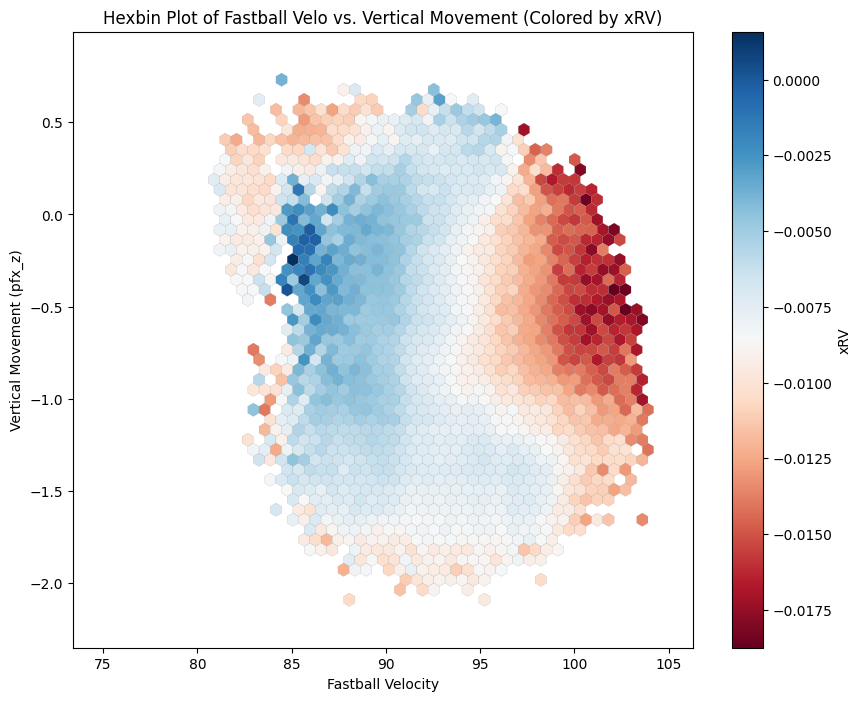

In [50]:
plt.figure(figsize=(10, 8))

# Create a hexbin plot
hb = plt.hexbin(
    x=fastball_df['release_speed'],
    y=fastball_df['pfx_x'],
    C=fastball_df['xRV'],
    gridsize=50,  # Adjust gridsize as needed
    cmap='RdBu',  # Choose a colormap
    mincnt=1,  # Set a minimum count for a bin to be colored
    edgecolors='gray',  # Color of hexagon edges
    linewidths=0.1,  # Width of hexagon edges
)

# Add a colorbar
cb = plt.colorbar(hb, label='xRV')

# Add labels and title
plt.xlabel('Fastball Velocity')
plt.ylabel('Vertical Movement (pfx_z)')
plt.title('Hexbin Plot of Fastball Velo vs. Vertical Movement (Colored by xRV)')

# Show the plot
plt.show()